In [357]:
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata 


from resipy import Project

In [3]:
# Ruta al archivo raster
path = r"C:\Users\eaqm1\Downloads\Zonas_potenciales_geoelectrica\ZPAG.tif"

# Abrir el archivo raster
with rasterio.open(path) as src:
    # Leer el raster como una matriz numpy
    raster = src.read(1)
    # Obtener la transformación del raster
    transform = src.transform

    rasterF = np.where((raster > 80) & (raster < 120), raster, np.NaN)
    left, bottom, right, top = src.bounds

# Generar una malla de coordenadas de píxeles
height, width = src.shape
y_coords, x_coords = np.mgrid[:height, :width]

# Transformar las coordenadas de píxeles a coordenadas de puntos en el mundo real
X, Y = rasterio.transform.xy(transform, y_coords.flatten(), x_coords.flatten())

# Obtener los valores del raster correspondientes a cada punto
P = rasterF[y_coords.flatten(), x_coords.flatten()]

idx = ~np.isnan(P) 
X = np.array(X)[idx]
Y = np.array(Y)[idx] 
P = P[idx]

XY = np.c_[X,Y]

In [4]:

def rand_uniform_subset(dataXY = None, random_number = 150, tol = 10, base_num_search = 1200, step=0.1):
    step = step*base_num_search

    while True:
        base_num_search += step 

        point_select = []
        XY_selec = dataXY

        while len(XY_selec) > 0:
            # print(XY_selec.shape)
            idx_fp = np.random.choice(np.arange(XY_selec.shape[0]))
            point = XY_selec[idx_fp]
            point_select.append(point)
            idx_select = ~(XY_selec == point).all(axis=1)
            XY_selec = XY_selec[idx_select]
            idxL = np.sqrt((point[0]-XY_selec[:,0])**2 + (point[1]-XY_selec[:,1])**2) > base_num_search
            XY_selec = XY_selec[idxL]
        point_select = np.stack(point_select)
        print(f"Radio: {base_num_search} || Puntos tomados aleatoriamente: {len(point_select)}")

        if len(point_select) < random_number + tol:
            break

    return(point_select)
ps = rand_uniform_subset(dataXY=XY.copy())

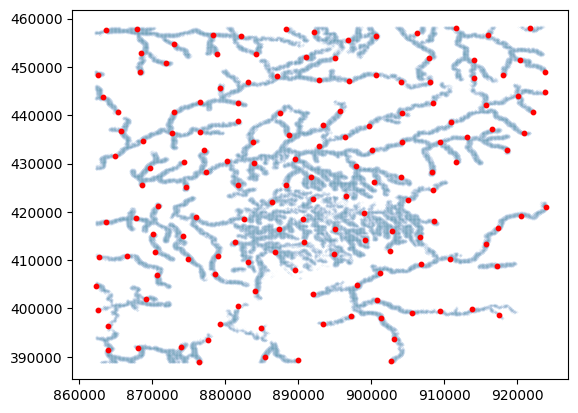

In [6]:
plt.scatter(X,Y, s=.0001)
plt.scatter(ps[:,0], ps[:,1], c='r', s=10)
# plt.scatter(point_select[:,0], point_select[:,1], c='g', s=5, marker='o')

#### Análsis exploratorio de datos

In [ ]:
k = Project(typ="R2")
k.createSurvey(r"C:/Users/eaqm1/OneDrive/Escritorio/ROLL-ALONG_Gradient XL_1.dat", ftype="ResInv")
x, _, z = k.surveys[0]._computePseudoDepth()
rho_a = k.surveys[0].df["app"].to_numpy().copy()

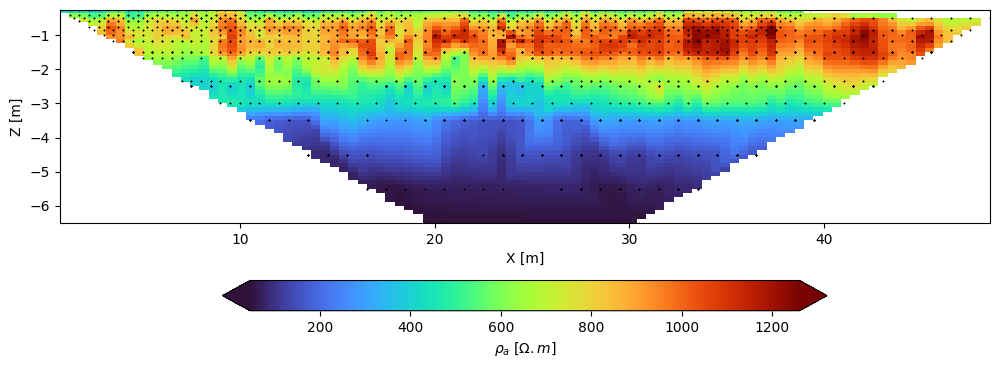

In [83]:
pseudo=True

if pseudo:
    color = 'k'
    size = 0.1 
    marker = '*'
else:
    color = rho_a
    size = 3
    marker = 's'

fig, ax = plt.subplots(1, 1, figsize=(12, 5))

if pseudo:
    xi = np.linspace(x.min(), x.max(), 100)
    zi = np.linspace(z.min(), z.max(), 50)
    XX, ZZ = np.meshgrid(xi, zi)
    rho_all = griddata((x, z), rho_a, (XX, ZZ), method="linear")
    plot = ax.imshow(rho_all, aspect=1.75, cmap='turbo', extent=[x.min(), x.max(), -z.max(), -z.min()])
    ax.scatter(x, -z, c=color, s=size, marker=marker)
else:
    plot = ax.scatter(x, -z, c=color, s=size, cmap='turbo', marker=marker)

ax.set_xlabel("X [m]")
ax.set_ylabel("Z [m]")

plt.colorbar(plot, ax=ax, label=r'$\rho_{a}$ [$\Omega.m$]', orientation='horizontal', shrink=0.65, pad=0.15, extend='both')


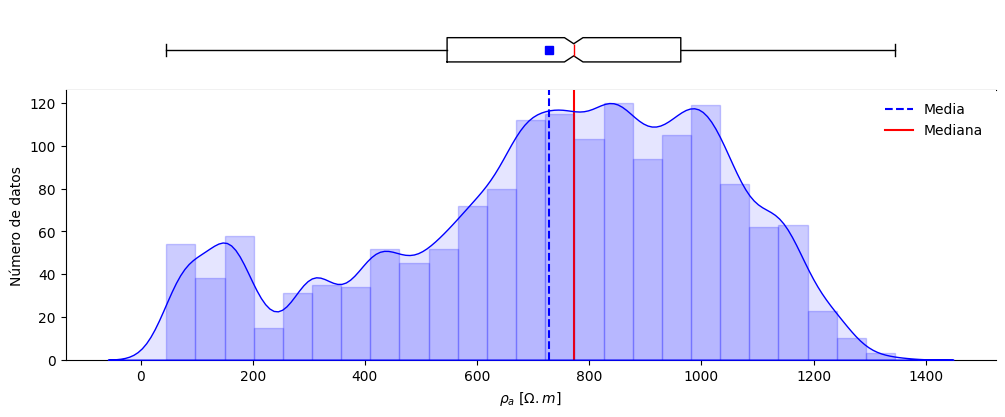

In [273]:
import seaborn as sns 

fig = plt.figure(figsize=(12,7))
gs = fig.add_gridspec(2, hspace=0)
ax = gs.subplots(sharex=True)
ax[0].boxplot(rho_a, vert=False, notch=True, showmeans=True, widths=.3,
              meanprops=dict(markerfacecolor='b', marker='s', markeredgecolor='b'),
              medianprops=dict(color="r"))

pos = ax[0].get_position()
ax[0].set_position([pos.x0, pos.y0, pos.width, pos.height * 0.3]) 
ax[0].set_yticks([])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)

ax[1].hist(rho_a,bins=25, color='b',alpha=.2, edgecolor='b')
ax[1].axvline(rho_a.mean(), color='b', linestyle='dashed', linewidth=1.5, label='Media')
ax[1].axvline(np.median(rho_a), color='r', linewidth=1.5, label='Mediana')
ax[1].set_xlabel(r'$\rho_{a}$ [$\Omega.m$]')
ax[1].set_ylabel(r'Número de datos')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

axd = ax[1].twinx()
sns.kdeplot(rho_a, ax=axd, bw_adjust=0.5, 
            color='b', alpha=.1, fill=True)
axd.set_axis_off()
ax[1].legend(frameon=False)




In [366]:
# Define the numpy array (aquí asumo que rho_a está definido previamente)
data = rho_a

# Calculate the metrics
n_samples = data.size
min_val = np.min(data, axis=0)
q1 = np.percentile(data, 25, axis=0)
median = np.median(data, axis=0)
mean = np.mean(data, axis=0)
q3 = np.percentile(data, 75, axis=0)
max_val = np.max(data, axis=0)
range_val = max_val - min_val
iqr = q3 - q1
variance = np.var(data, axis=0)
std_dev = np.std(data, axis=0)
skewness = (mean - median) / std_dev
kurtosis = np.mean(((data - mean) / std_dev) ** 4) 

# Create a table as a list of lists
table = [
    ["Estadígrafo", "Valor"],
    ["n-datos", n_samples],
    ["Mín", min_val],
    ["Q1", q1],
    ["Mediana", median],
    ["Media", mean],
    ["Q3", q3],
    ["Máx", max_val],
    ["Rango", range_val],
    ["IQR", iqr],
    ["Varianza", variance],
    ["Desv. estándar", std_dev],
    ["Simetría", skewness],
    ["Curtosis", kurtosis]
]

df = pd.DataFrame(table[1:], columns=table[0])
df['Valor'] = df['Valor'].round(2)

df

,Estadígrafo,Valor
0,n-datos,1577.00
1,Mín,45.88
2,Q1,546.50
3,Mediana,772.30
4,Media,728.44
5,Q3,963.21
6,Máx,1345.13
7,Rango,1299.24
8,IQR,416.71
9,Varianza,91595.73


In [ ]:
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata 
from resipy import Project

# Ruta al archivo raster
path = r"C:\Users\eaqm1\Downloads\Zonas_potenciales_geoelectrica\ZPAG.tif"

# Abrir el archivo raster
with rasterio.open(path) as src:
    # Leer el raster como una matriz numpy
    raster = src.read(1)
    # Obtener la transformación del raster
    transform = src.transform

    rasterF = np.where((raster > 80) & (raster < 120), raster, np.NaN)
    left, bottom, right, top = src.bounds

# Generar una malla de coordenadas de píxeles
height, width = src.shape
y_coords, x_coords = np.mgrid[:height, :width]

# Transformar las coordenadas de píxeles a coordenadas de puntos en el mundo real
X, Y = rasterio.transform.xy(transform, y_coords.flatten(), x_coords.flatten())

# Obtener los valores del raster correspondientes a cada punto
P = rasterF[y_coords.flatten(), x_coords.flatten()]

idx = ~np.isnan(P) 
X = np.array(X)[idx]
Y = np.array(Y)[idx] 
P = P[idx]

XY = np.c_[X,Y]

def rand_uniform_subset(dataXY = None, random_number = 150, tol = 10, base_num_search = 1200, step=0.1):
    step = step*base_num_search

    while True:
        base_num_search += step 

        point_select = []
        XY_selec = dataXY

        while len(XY_selec) > 0:
            # print(XY_selec.shape)
            idx_fp = np.random.choice(np.arange(XY_selec.shape[0]))
            point = XY_selec[idx_fp]
            point_select.append(point)
            idx_select = ~(XY_selec == point).all(axis=1)
            XY_selec = XY_selec[idx_select]
            idxL = np.sqrt((point[0]-XY_selec[:,0])**2 + (point[1]-XY_selec[:,1])**2) > base_num_search
            XY_selec = XY_selec[idxL]
        point_select = np.stack(point_select)
        print(f"Radio: {base_num_search} || Puntos tomados aleatoriamente: {len(point_select)}")

        if len(point_select) < random_number + tol:
            break

    return(point_select)
ps = rand_uniform_subset(dataXY=XY.copy())
k = Project(typ="R2")
k.createSurvey(r"C:/Users/eaqm1/OneDrive/Escritorio/ROLL-ALONG_Gradient XL_1.dat", ftype="ResInv")
x, _, z = k.surveys[0]._computePseudoDepth()
rho_a = k.surveys[0].df["app"].to_numpy().copy()
pseudo=True

if pseudo:
    color = 'k'
    size = 0.1 
    marker = '*'
else:
    color = rho_a
    size = 3
    marker = 's'

fig, ax = plt.subplots(1, 1, figsize=(12, 5))

if pseudo:
    xi = np.linspace(x.min(), x.max(), 100)
    zi = np.linspace(z.min(), z.max(), 50)
    XX, ZZ = np.meshgrid(xi, zi)
    rho_all = griddata((x, z), rho_a, (XX, ZZ), method="linear")
    plot = ax.imshow(rho_all, aspect=1.75, cmap='turbo', extent=[x.min(), x.max(), -z.max(), -z.min()])
    ax.scatter(x, -z, c=color, s=size, marker=marker)
else:
    plot = ax.scatter(x, -z, c=color, s=size, cmap='turbo', marker=marker)

ax.set_xlabel("X [m]")
ax.set_ylabel("Z [m]")

plt.colorbar(plot, ax=ax, label=r'$\rho_{a}$ [$\Omega.m$]', orientation='horizontal', shrink=0.65, pad=0.15, extend='both')
import seaborn as sns 

fig = plt.figure(figsize=(12,7))
gs = fig.add_gridspec(2, hspace=0)
ax = gs.subplots(sharex=True)
ax[0].boxplot(rho_a, vert=False, notch=True, showmeans=True, widths=.3,
              meanprops=dict(markerfacecolor='b', marker='s', markeredgecolor='b'),
              medianprops=dict(color="r"))

pos = ax[0].get_position()
ax[0].set_position([pos.x0, pos.y0, pos.width, pos.height * 0.3]) 
ax[0].set_yticks([])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['left'].set_visible(False)

ax[1].hist(rho_a,bins=25, color='b',alpha=.2, edgecolor='b')
ax[1].axvline(rho_a.mean(), color='b', linestyle='dashed', linewidth=1.5, label='Media')
ax[1].axvline(np.median(rho_a), color='r', linewidth=1.5, label='Mediana')
ax[1].set_xlabel(r'$\rho_{a}$ [$\Omega.m$]')
ax[1].set_ylabel(r'Número de datos')
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)

axd = ax[1].twinx()
sns.kdeplot(rho_a, ax=axd, bw_adjust=0.5, 
            color='b', alpha=.1, fill=True)
axd.set_axis_off()
ax[1].legend(frameon=False)
# Define the numpy array (aquí asumo que rho_a está definido previamente)
data = rho_a

# Calculate the metrics
n_samples = data.size
min_val = np.min(data, axis=0)
q1 = np.percentile(data, 25, axis=0)
median = np.median(data, axis=0)
mean = np.mean(data, axis=0)
q3 = np.percentile(data, 75, axis=0)
max_val = np.max(data, axis=0)
range_val = max_val - min_val
iqr = q3 - q1
variance = np.var(data, axis=0)
std_dev = np.std(data, axis=0)
skewness = (mean - median) / std_dev
kurtosis = np.mean(((data - mean) / std_dev) ** 4) 

# Create a table as a list of lists
table = [
    ["Estadígrafo", "Valor"],
    ["n-datos", n_samples],
    ["Mín", min_val],
    ["Q1", q1],
    ["Mediana", median],
    ["Media", mean],
    ["Q3", q3],
    ["Máx", max_val],
    ["Rango", range_val],
    ["IQR", iqr],
    ["Varianza", variance],
    ["Desv. estándar", std_dev],
    ["Simetría", skewness],
    ["Curtosis", kurtosis]
]

df = pd.DataFrame(table[1:], columns=table[0])
df['Valor'] = df['Valor'].round(2)

df